## Load the dataset

In [1]:
from datasets import load_dataset, load_metric

code_dataset = load_dataset("json", data_files="/mnt/data/andre/mscthesis/perturbations_buglab/generated_defects4j_buglab/*.json", field="bugs")
code_dataset

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Using custom data configuration default-7d721f3b83caa41e
Reusing dataset json (/home/andre/.cache/huggingface/datasets/json/default-7d721f3b83caa41e/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['identifier', 'path', 'diff', 'context', 'perturb_rule'],
        num_rows: 424599
    })
})

## Perturbation Rules Analysis

In [2]:
rule_frequency = {}
for example in code_dataset["train"]:
    if example["perturb_rule"] in rule_frequency:
        rule_frequency[example["perturb_rule"]] += 1
    else:
        rule_frequency[example["perturb_rule"]] = 1

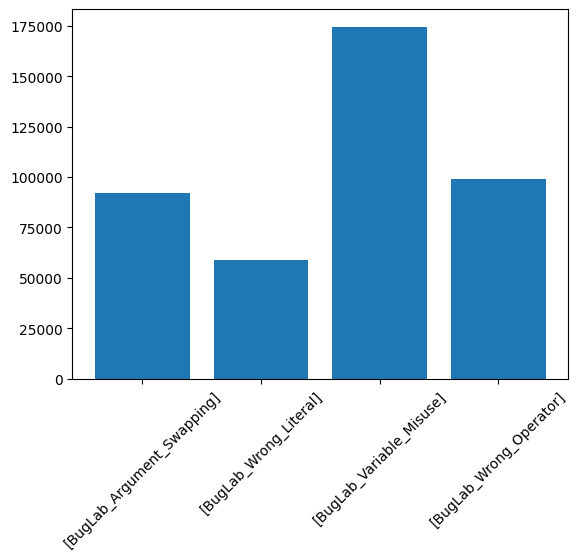

In [3]:
import matplotlib.pyplot as plt

plt.bar(rule_frequency.keys(), rule_frequency.values())
plt.xticks(rotation = 45)
plt.show()

## Tokenization Analysis

In [4]:
from unidiff import PatchSet
from src.model_utils import source_str, target_str

In [5]:
from transformers import AutoTokenizer, PLBartTokenizer

tokenizer = PLBartTokenizer.from_pretrained("experiments/defects4j_buglab/round0/fixer")
tokenizer.add_tokens(['[CONTEXT]','[CLASS]','[METHOD]','[RETURN_TYPE]','[VARIABLES]'])
tokenizer

PreTrainedTokenizer(name_or_path='experiments/defects4j_buglab/round0/fixer', vocab_size=50005, model_max_len=1024, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True), 'additional_special_tokens': ['java', 'python', 'en_XX']})

In [ ]:
source_frequency = {}
target_frequency = {}
for i, example in enumerate(code_dataset["train"]):
    if i < 1:
        print(source_str(example["diff"], example["context"]))
    l = len(tokenizer(source_str(example["diff"], example["context"])).input_ids)
    if l in source_frequency:
        source_frequency[l] += 1
    else:
        source_frequency[l] = 1        
    l = len(tokenizer(target_str(example["diff"])).input_ids)
    if l in target_frequency:
        target_frequency[l] += 1
    else:
        target_frequency[l] = 1

698


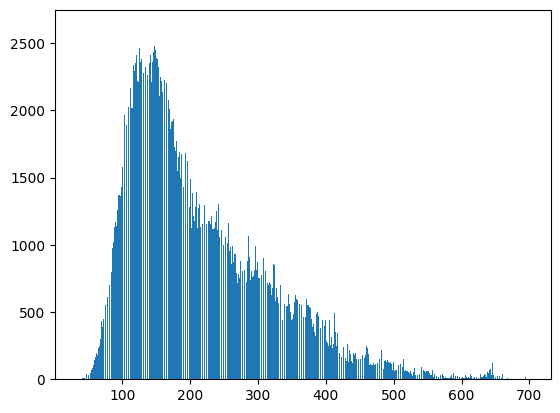

106


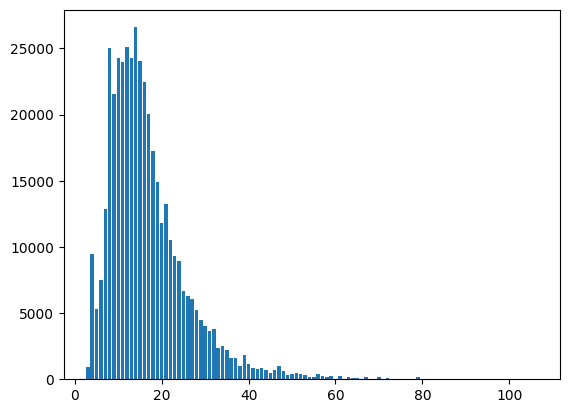

In [45]:
import matplotlib.pyplot as plt

print(max(source_frequency.keys()))
plt.bar(source_frequency.keys(), source_frequency.values())
plt.show()

print(max(target_frequency.keys()))
plt.bar(target_frequency.keys(), target_frequency.values())
plt.show()